In [2]:
import scanpy as sc
import os
os.environ["R_HOME"]="/usr/lib/R/"

In [3]:
adata=sc.read_mtx_gpu("old/whole_neocortex/matrix.mtx.gz")

In [5]:
import pandas as pd
adata.var_names=pd.read_table("old/whole_neocortex/features.tsv",header=None).iloc[:,0].values
adata.obs_names=pd.read_table("old/whole_neocortex/barcodes.tsv",header=None).iloc[:,0].values

In [6]:
adata.obs["devtime"]=[s[0] for s in adata.obs_names.str.split("_")]

In [9]:
meta=pd.read_table("old/whole_neocortex/metaData_scDevSC.txt")

/tmp/ipykernel_771480/3982609037.py:1: DtypeWarning: Columns (2,3,4,5,6,7,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  meta=pd.read_table("old/whole_neocortex/metaData_scDevSC.txt")


In [10]:
adata.obs["celltype"]=meta["New_cellType"].iloc[1:].values

In [11]:
#adata=adata[adata.obs.devtime=="E13"]
adata.obs["samples"]=[s[1] for s in adata.obs_names.str.split("_")]

In [12]:
adata.var["mito"]=adata.var_names.str.startswith("mt-")

In [13]:
sc.pp.calculate_qc_metrics(adata,qc_vars=["mito"],log1p=None,percent_top=None,inplace=True)

... storing 'devtime' as categorical
... storing 'celltype' as categorical
... storing 'samples' as categorical


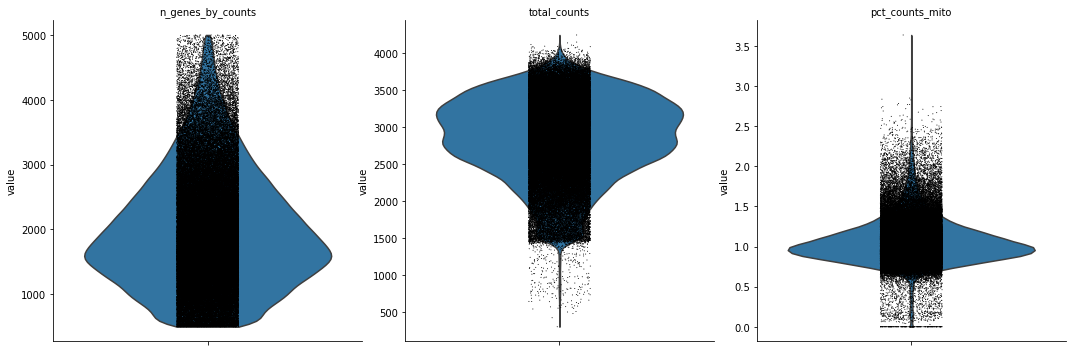

In [14]:
sc.pl.violin(adata,keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],multi_panel=True)

In [15]:
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata,n_top_genes=3000)

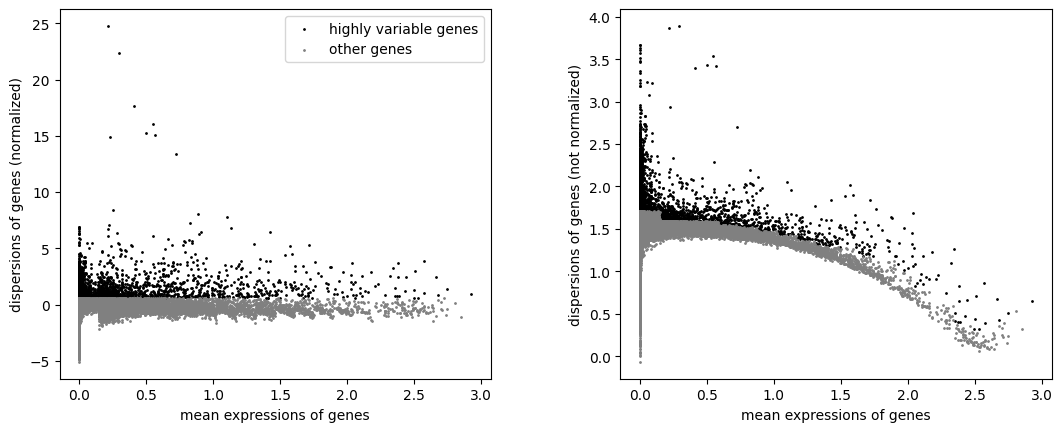

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
import scvelo as scv
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


In [19]:
adata.obs["CC"]=adata.obs.S_score-adata.obs.G2M_score

In [20]:
adata.raw=adata

In [21]:
adata=adata[:,adata.var.highly_variable]

In [22]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mito',"n_genes_by_counts","CC"],n_jobs=20)

Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


In [23]:
sc.pp.pca(adata,svd_solver="auto",device="gpu")

In [24]:
sc.pp.neighbors(adata,n_neighbors=30,n_pcs=50,method="rapids")

In [25]:
sc.tl.umap(adata,method="rapids")

In [26]:
sc.tl.leiden(adata,flavor="rapids",resolution=.3)

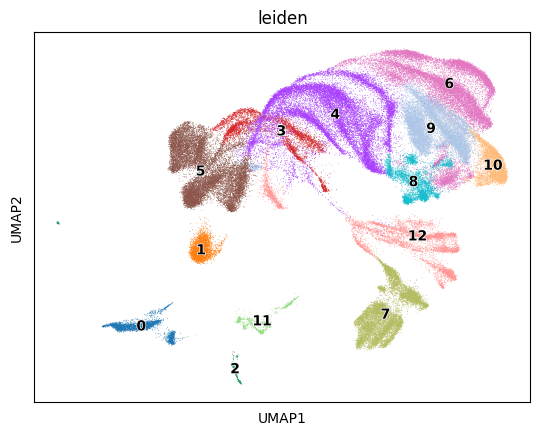

In [27]:
sc.pl.umap(adata,color="leiden",legend_loc="on data",legend_fontoutline=True)

In [28]:
import scFates as scf

In [31]:
sc.pp.neighbors(adata,n_neighbors=200,n_pcs=50,method="rapids")

In [32]:
adata.write("old/whole_neocortex/adata_processed.h5ad")